# Homework 5
**Author:** David James

**Date:** 2019 February 19

### Problem 1: Fit Steinhart and Hart Equation
- Equation: 
$ \frac{1}{T} = A + B (\ln(R)) + C (\ln(R))^2 + D (\ln(R))^3 $

In [ ]:
import matplotlib.pyplot as plt
import datetime as dt
import scipy.io as sio
import numpy as np
from lmfit import minimize, Parameters
now = dt.datetime.now().strftime("%Y-%m-%d")

In [ ]:
prob1Data = sio.loadmat('Therm3950_Data.mat')
T = np.concatenate(prob1Data['Temp_degK'])
R = np.concatenate(prob1Data['Resist_Ohm'])

lv = ((T >= 273.15) & (T < 323.15))
tlv = T[lv]
rlv = R[lv]

In [ ]:
params = Parameters()
params.add('a', value=1e-3)
params.add('b',value=1e-4)
params.add('c',value=1e-7)
params.add('d',value=1e-8)

def steinhart(a,b,c,d,res):
    return (a + b*np.log(res)+c*np.log(res)**2+d*np.log(res)**3)**(-1)

def residual(params,temp,res):
    a = params['a']
    b = params['b']
    c = params['c']
    d = params['d']
    return steinhart(a,b,c,d,res) - temp

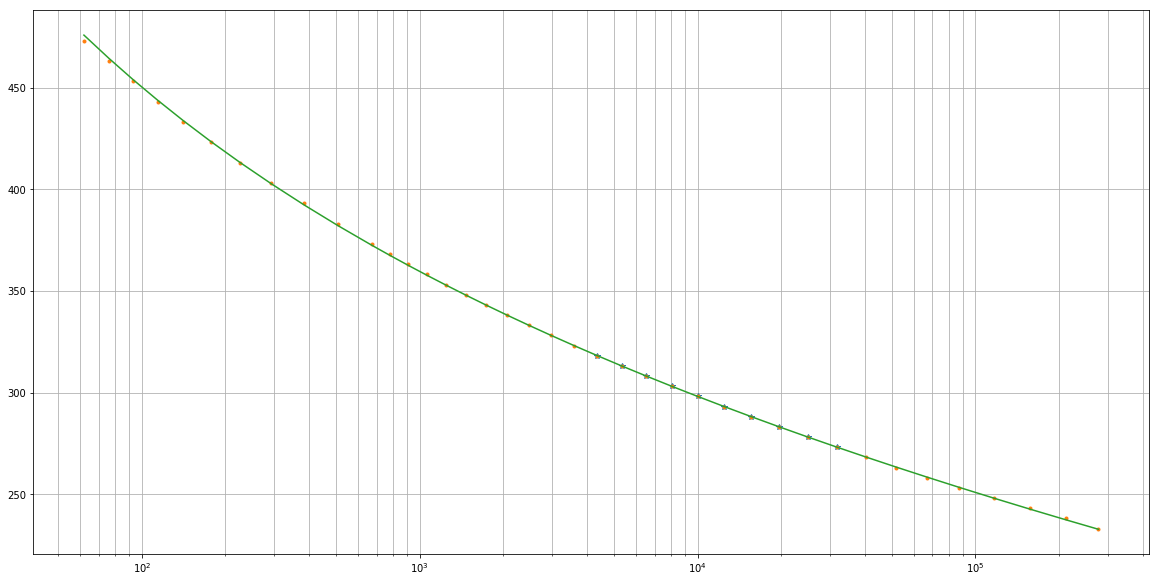

In [52]:
out = minimize(residual,params,args=(tlv,rlv))
a = out.params['a'].value
b = out.params['b'].value
c = out.params['c'].value
d = out.params['d'].value

fig = plt.figure(figsize=(20,10))
plt.semilogx(rlv,tlv,'*')
plt.semilogx(R,T,'.')
plt.semilogx(R,(steinhart(a,b,c,d,R))**(-1))
plt.grid(which='both')

### Problem 2

- create function that converts a given thermistor resistance into a temperature in degrees Celsius

In [ ]:
def temp3950(res):
    return steinhart(a,b,c,d,res) - 273.15

### Problem 3

- create a function that converts voltage measured into a resistance
- [arduino library](https://hub.packtpub.com/prototyping-arduino-projects-using-python/)

In [ ]:
def rst3950(volt):
    voltTotal = 5
    resFixed = 10
    return volt/(voltTotal - volt)*resFixed